In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as web
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from scipy.stats import norm
import datetime as dt
import numpy_financial as npf
style.use('ggplot')
import scipy
from scipy.stats import binom
import statistics
import openpyxl
import xlsxwriter
from pathlib import Path
import os


try:
    os.makedirs("Resultados")
except FileExistsError:
    # directory already exists
    pass

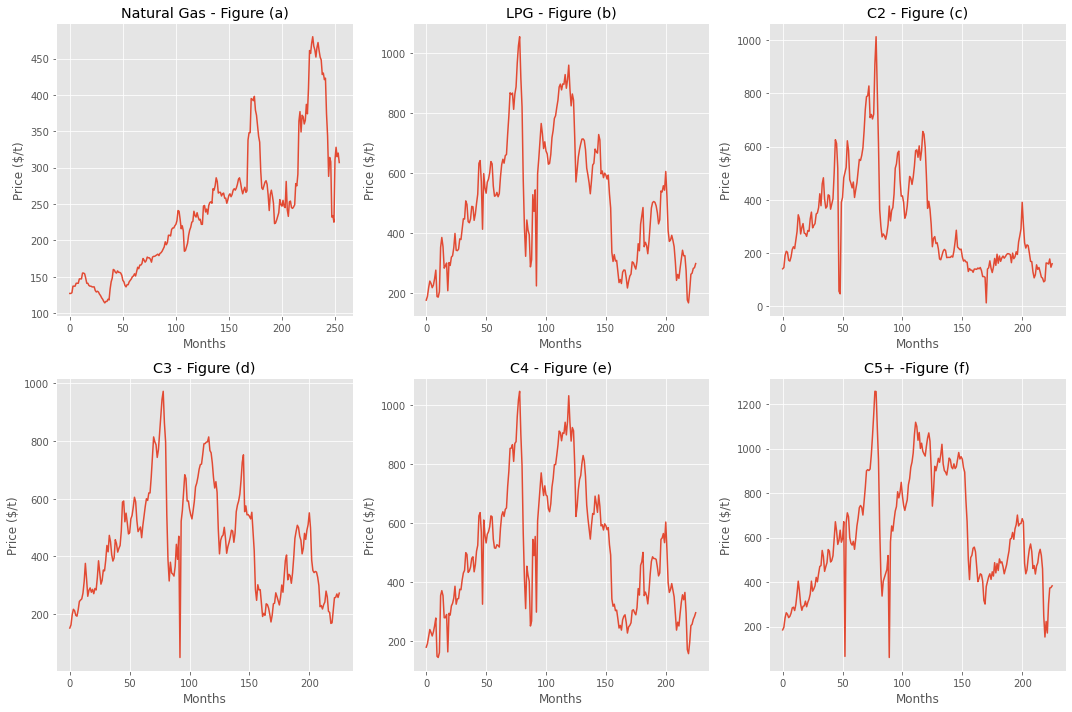

In [2]:
strategies = ['energetic','petrochemical']

prices_products = []

prices = pd.read_csv('products_prices.csv',sep= ';')

prices_gn = prices.iloc[:,1]
prices_glp = prices.iloc[:,2]
prices_glp = prices_glp[0:226]
prices_c5 = prices.iloc[:,3]
prices_c5 = prices_c5[0:226]
prices_c2 = prices.iloc[:,4]
prices_c2 = prices_c2[0:226]
prices_c3 = prices.iloc[:,5]
prices_c3 = prices_c3[0:226]
prices_c4 = prices.iloc[:,6]
prices_c4 = prices_c4[0:226]


prices_products.append(prices_gn)
prices_products.append(prices_glp)
prices_products.append(prices_c5)
prices_products.append(prices_c2)
prices_products.append(prices_c3)
prices_products.append(prices_c4)

bins_number = 30


fig, axs = plt.subplots(2,3,figsize=(15,10))

axs[0, 0].plot(prices_gn)
axs[0, 0].set_title('Natural Gas - Figure (a)')
axs[1, 0].plot(prices_c3)
axs[1, 0].set_title('C3 - Figure (d)')
axs[0, 1].plot(prices_glp)
axs[0, 1].set_title('LPG - Figure (b)')
axs[0, 2].plot(prices_c2)
axs[0, 2].set_title('C2 - Figure (c)')
axs[1, 1].plot(prices_c4)
axs[1, 1].set_title('C4 - Figure (e)')
axs[1, 2].plot(prices_c5)
axs[1, 2].set_title('C5+ -Figure (f)')
for ax in axs.flat:
    ax.set(xlabel='Months', ylabel='Price ($/t)')
fig.tight_layout()

fig.savefig('Resultados/prices_historical.png')


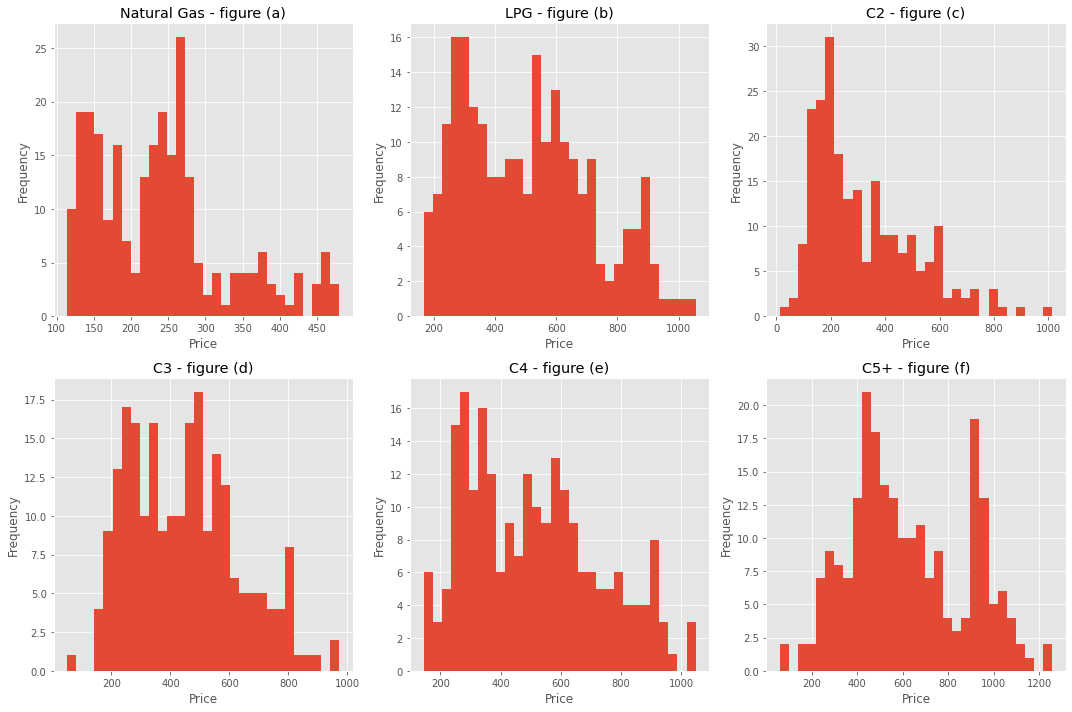

In [3]:
fig, axs = plt.subplots(2,3,figsize=(15,10))
axs[0, 0].hist(prices_gn, bins = bins_number )
axs[0, 0].set_title('Natural Gas - figure (a)')
axs[1, 0].hist(prices_c3, bins = bins_number)
axs[1, 0].set_title('C3 - figure (d)')
axs[0, 1].hist(prices_glp, bins = bins_number)
axs[0, 1].set_title('LPG - figure (b)')
axs[0, 2].hist(prices_c2, bins = bins_number)
axs[0, 2].set_title('C2 - figure (c)')
axs[1, 1].hist(prices_c4, bins = bins_number)
axs[1, 1].set_title('C4 - figure (e)')
axs[1, 2].hist(prices_c5, bins = bins_number)
axs[1, 2].set_title('C5+ - figure (f)')
for ax in axs.flat:
    ax.set(xlabel='Price', ylabel='Frequency')
fig.tight_layout()

# Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axs.flat:
#    ax.label_outer()
fig.savefig('Resultados/prices_hist.png')

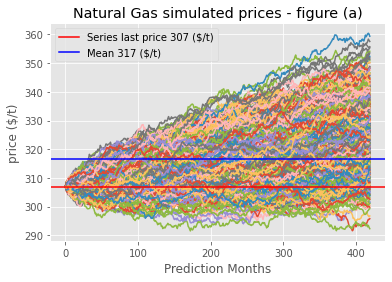

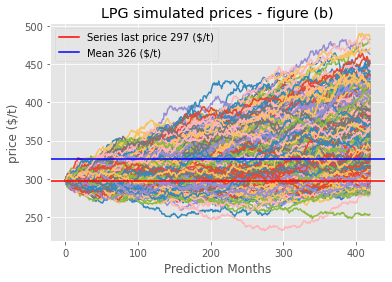

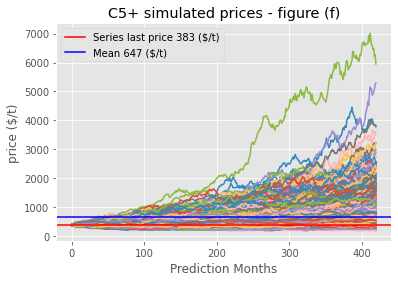

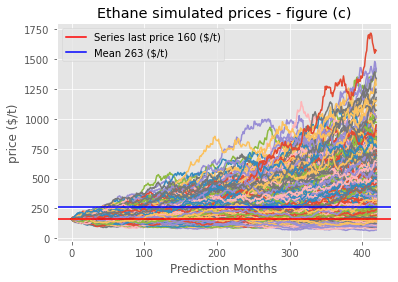

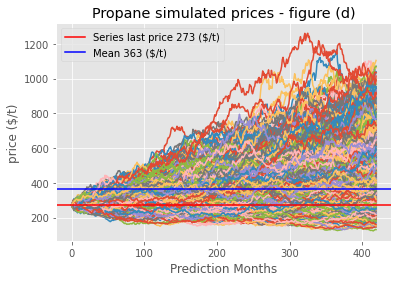

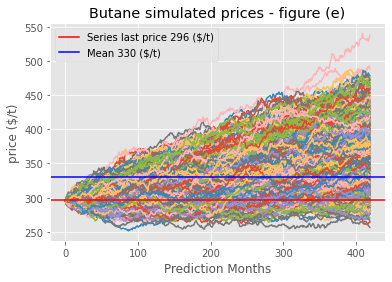

In [4]:
anos_simulacao = 35
scen_size = 1000
precos_anuais = [] 
precos_simulados = []
letters = ['a','b','f','c','d','e']
for counter,produto in enumerate(prices_products):
    name = produto.name
    returns = produto.pct_change()
    last_price = produto.iloc[-1]
    so = produto.iloc[-1]
    dt = 1
    T = 12*anos_simulacao - 1
    N = T / dt
    mu = np.mean(returns)/anos_simulacao
    sigma = np.std(returns)/anos_simulacao
    t = np.arange(1, int(N) + 1)

    b = {str(scen): np.random.normal(0, 1, int(N)) for scen in range(1, scen_size + 1)}
    W = {str(scen): b[str(scen)].cumsum() for scen in range(1, scen_size + 1)}
    
    drift = (mu - 0.5 * sigma**2) * t
    #print("drift:\n", drift)
    diffusion = {str(scen): sigma * W[str(scen)] for scen in range(1, scen_size + 1)}
    #print("diffusion:\n", diffusion)
    
    S = np.array([so * np.exp(drift + diffusion[str(scen)]) for scen in range(1, scen_size + 1)]) 
    S = np.hstack((np.array([[so] for scen in range(scen_size)]), S)) # add So to the beginning series
    precos_simulados.append(S)

    for i in range(scen_size-1):
        plt.title("{} simulated prices - figure ({})".format(name,letters[counter]))
        plt.plot(S[i, :])
        plt.ylabel('price ($/t)'.format(name))
        plt.xlabel('Prediction Months')
    plt.axhline(y=last_price,color = 'r',label = 'Series last price {} ($/t)'.format(round(last_price)))
    plt.axhline(y=S.mean(),color = 'b',label = 'Mean {} ($/t)'.format(round(S.mean())))
    plt.legend()
    plt.savefig('Resultados/prices_from_{}.png'.format(name))
    plt.show()
    
    
    
    S = pd.DataFrame(S)
    S = S.T
    S.to_csv(('Resultados/prices_from_{}.csv'.format(name)))
    for coluna in S:
        a = np.array(S.iloc[:,coluna])
        a = a.reshape([anos_simulacao,12])
        medias = np.mean(a,axis = 1)
        precos_anuais.append(medias)
        
precos_anuais = np.array_split(precos_anuais, len(prices_products))



In [5]:
#econômicos


custo_compressores = 0 # US$/HP
consumo_gas_compressores = 0 #  (m3/dia)/HP
preco_gas_combustivel = 0 # US$/M BTU
taxa_atratividade = 0.07 # a.a
taxa_cambio = 5.25 # R$/US$


imposto_renda = 0.25 # LAIR
csll = 0.09 # LAIR
pis = 0.0165 # Receita Bruta
cofins = 0.0760 # Receita Bruta 
iss = 0.05 # Receita Bruta
outros = 0.12 # Receita Bruta
tempo_depreciacao = 30 #anos
percentual_depreciacao = 1/tempo_depreciacao # %


tempo_amortizacao = 20
juros_captacao = 0

capital_terceiros = 0 #Million

tempo_inicio_amortizacao = 10 #anos
valor_futuro_capital = 0 #Million
pagamentos = 0 #Million


quantidade_anos = int(T/12)
anos_investimento = 5
anos = list(range(1, quantidade_anos+1))
anos_valor = list(range(2020, 2020+quantidade_anos+1))

# natural gas flow (Mm3/d)
ng_flow = [0.0048,0.0095,0.0087,0.0166,0.0225,0.0371,0.0391,0.0411,0.0431,0.0451,0.0471,0.0491,0.0512,0.0532,0.0552,0.0572,0.0595,0.0618,0.0642,0.0665,0.0688,0.0712,0.0735,0.0758,0.0781,0.0805]


while len(ng_flow) < len(anos):
    ng_flow.append(ng_flow[-1])

    #pipeline
custo_unitario = 212 #US$/in.m
diametro = 32 # in
comprimento = 0 # km
pipeline_opex = 0.04 # % a.a. x Inv.

pipeline_capital = custo_unitario * diametro * comprimento # US$  Millions
pipelie_operational_cost = pipeline_capital * pipeline_opex  # US$  Millions

pipeline_total_cost = pipeline_capital + pipelie_operational_cost


pipeline_investiment_distribution = {'y1':0.3,
                                'y2':0.3,
                                'y3':0.2,
                                'y4':0.1,
                                'y5':0.1}

pipeline_investiment_distribution = pd.Series(pipeline_investiment_distribution)


#compressor station

power = 0 #HP
number_station = 0 # units
new_station_cost = 600 #US$  Millions
compressor_opex = 0.04 #  % a.a. x Inv.

compressor_capital = number_station * new_station_cost  #US$  Millions
compressor_operational_cost = compressor_capital * compressor_opex #US$  Millions

compressions_total_cost = compressor_capital + compressor_operational_cost #US$  Millions


compressor_investiment_distribution = {'y1':0.3,
                                'y2':0.3,
                                'y3':0.2,
                                'y4':0.1,
                                'y5':0.1}

compressor_investiment_distribution = pd.Series(compressor_investiment_distribution)



# NPGU

raw_ng_processing_capacity = 40.7 # M m3/day
npgu_modules  = 1 # units
unitary_value_Per_module = 1156.25179848225 #US$  Millions

npgu_capital = npgu_modules * unitary_value_Per_module #US$  Millions
processing_factor = 0.91 # %
produced_dry_ng = raw_ng_processing_capacity * processing_factor  # M m3/day

npgu_opex = 0.05 #  % a.a. x Inv.
npgu_operational_cost = produced_dry_ng * npgu_opex #US$  Millions



npgu_investiment_distribution = {'y1':0.3,
                                'y2':0.3,
                                'y3':0.2,
                                'y4':0.1,
                                'y5':0.1}

npgu_investiment_distribution = pd.Series(npgu_investiment_distribution)



# steam craker

ethane_production_capacity_m3 = 0  # M m3/day
ethane_production_capacity_mt = (ethane_production_capacity_m3 * 2) / (22.4 * 1000) #Mt/day
ethane_production_capacity_year = ethane_production_capacity_mt * 365 #Mt/year
h2_unitary_value = 2080 #US$/t H2
steam_cracker_opex = 0.04  #  % a.a. x Inv.

steam_cracker_capital = ethane_production_capacity_year * h2_unitary_value / 10**6 # US$, Millions
steam_cracker_operational_cost = steam_cracker_capital * steam_cracker_opex # US$, Millions



steam_creaker_investiment_distribution = {'y1':0.3,
                                'y2':0.3,
                                'y3':0.2,
                                'y4':0.1,
                                'y5':0.1}
steam_creaker_investiment_distribution = pd.Series(steam_creaker_investiment_distribution)



#nomial values

pipeline_nominal_values = pipeline_investiment_distribution * pipeline_total_cost
compressor_nominal = compressor_investiment_distribution * compressions_total_cost
npgu_nomial = npgu_investiment_distribution * npgu_capital
srm_nominal = steam_creaker_investiment_distribution * steam_cracker_capital


In [6]:
vpl_strategies = pd.DataFrame()
for strategy in strategies:
    vpl_strategy = []
    
    
    for preco_anual_gn,preco_anual_glp,preco_anual_c5,preco_anual_c2,preco_anual_c3,preco_anual_c4 in zip(precos_anuais[0],
                                                                                                          precos_anuais[1],
                                                                                                          precos_anuais[2],
                                                                                                         precos_anuais[3],
                                                                                                         precos_anuais[4],
                                                                                                         precos_anuais[5]):

            #capital investment

        capital_investment = pipeline_nominal_values + compressor_nominal + npgu_nomial + srm_nominal
        capital_investment_total = capital_investment.sum()

            #operational costs
        operacional_costs = pipelie_operational_cost + compressor_operational_cost + npgu_operational_cost + steam_cracker_operational_cost

        depreciacao = capital_investment_total * percentual_depreciacao


        operacional_total = []
        soma_opex = operacional_costs + depreciacao + pagamentos
        operacional_total.append(soma_opex)


        while len(operacional_total) < anos_simulacao-5:
            operacional_total.append(soma_opex)

        operacional_total = pd.Series(operacional_total)
        operacional_total_soma = operacional_total.sum()



        #Gross Income
        #gás natural
        
        if strategy == 'energetic':
        
        
            preço_gas = pd.Series(preco_anual_gn[5:])
            prod_anual =  1453*1000 # t/year
            fluxo_caixa = (preço_gas * prod_anual)/10**6

            #GLP
            preco_glp = pd.Series(preco_anual_glp[5:])
            #preco_lpg = 187.920189907168
            prod_anual_lgp = 466.7*1000 # t/year
            fluxo_caixa_lpg = (preco_glp*prod_anual_lgp)/10**6


            #C5+
            preco_c5 = pd.Series(preco_anual_c5[5:])
            prod_anual_c5 = 66.6*1000 # t/year
            fluxo_caixa_c5 = (preco_c5 * prod_anual_c5)/10**6



            soma_receitas = fluxo_caixa_c5 + fluxo_caixa_lpg + fluxo_caixa
            soma_receitas_total = soma_receitas.sum()
        
        if strategy == 'petrochemical':
        
        
                    #gás natural
            preço_gas = pd.Series(preco_anual_gn[5:])
            prod_anual =  1453*1000 # t/year
            fluxo_caixa = (preço_gas * prod_anual)/10**6



            #ethano
            preço_c2 = pd.Series(preco_anual_c2[5:])
            prod_anual_c2 =  330*1000 # t/year
            fluxo_caixa_c2 = (preço_c2 * prod_anual_c2)/10**6


            #propano
            preço_c3 = pd.Series(preco_anual_c3[5:])
            prod_anual_c3 =  316*1000 # t/year
            fluxo_caixa_c3 = (preço_c3 * prod_anual_c3)/10**6



            #butano
            preço_c4 = pd.Series(preco_anual_c4[5:])
            prod_anual_c4 =  171*1000 # t/year
            fluxo_caixa_c4 = (preço_c4 * prod_anual_c4)/10**6    



            #C5+
            preco_c5 = pd.Series(preco_anual_c5[5:])
            prod_anual_c5 = 66.6*1000 # t/year
            fluxo_caixa_c5 = (preco_c5 * prod_anual_c5)/10**6



            soma_receitas = fluxo_caixa_c2+ fluxo_caixa_c3 + fluxo_caixa_c4 + fluxo_caixa_c5 + fluxo_caixa
            soma_receitas_total = soma_receitas.sum()

            #taxes

        tax_pis = soma_receitas * pis
        tax_coffis = soma_receitas * cofins
        tax_iss = soma_receitas * iss
        tax_outros = soma_receitas * outros

        tax_soma = tax_pis + tax_coffis + tax_iss + tax_outros



            #net income
        net_income = soma_receitas - tax_soma 

            #lair
        lair = net_income - operacional_total


            #imposto de renda
        ir = lair * imposto_renda


        csll_fluxo = []

        for i,j in zip(net_income,lair):
            if j <= 0:
                csll_fluxo.append(0)
            else:
                valor = i * csll
                csll_fluxo.append(valor)

        csll_fluxo = pd.Series(csll_fluxo)

        lucro_liquido = lair - ir - csll_fluxo



        fluxo_geral = soma_receitas - operacional_total - tax_soma - ir - csll_fluxo + depreciacao



            #calculo do vpl



        fluxo_de_caixa_final = capital_investment * -1
        fluxo_de_caixa_final = fluxo_de_caixa_final.append(fluxo_geral)

        vpl = npf.npv(taxa_atratividade, fluxo_de_caixa_final)

        vpl_strategy.append(vpl)
        
    vpl_strategies[strategy] = vpl_strategy


Area under curves  0.07294393467863838


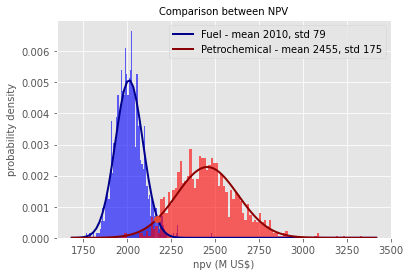

In [7]:

mu_energetic, std_energetic = norm.fit (vpl_strategies['energetic']) # mean and standard deviation
mu_petro, std_petro = norm.fit (vpl_strategies['petrochemical'])
plt.hist(vpl_strategies['energetic'], bins=100, density=True, alpha=0.6, color='b')
plt.hist(vpl_strategies['petrochemical'], bins=100, density=True, alpha=0.6, color='r')


def solve(m1,m2,std1,std2):
  a = 1/(2*std1**2) - 1/(2*std2**2)
  b = m2/(std2**2) - m1/(std1**2)
  c = m1**2 /(2*std1**2) - m2**2 / (2*std2**2) - np.log(std2/std1)
  return np.roots([a,b,c])


#Get point of intersect
result = solve(mu_energetic,mu_petro,std_energetic,std_petro)
result =result[0]



xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p1 = norm.pdf(x, mu_energetic, std_energetic)
p2 = norm.pdf(x, mu_petro, std_petro)


plt.plot(x, p1, 'darkblue', linewidth=2, label = 'Fuel - mean {}, std {}'.format(round(mu_energetic),round(std_energetic)))
plt.plot(x, p2, 'darkred', linewidth=2, label = 'Petrochemical - mean {}, std {}'.format(round(mu_petro),round(std_petro)))
plt.plot(result,norm.pdf(result,mu_energetic,std_energetic),'o')
r = result
olap = plt.fill_between(x[x>r], 0, norm.pdf(x[x>r],mu_energetic,std_energetic),alpha=0.3,facecolor='black')
olap = plt.fill_between(x[x<r], 0, norm.pdf(x[x<r],mu_petro,std_petro),alpha=0.3,facecolor='black')
area = norm.cdf(r,mu_petro,std_petro) + (1.-norm.cdf(r,mu_energetic,std_energetic))
print("Area under curves ", area)
title = "Comparison between NPV"
plt.title(title, fontsize = 10)
plt.xlabel('npv (M US$)', fontsize=10)
plt.ylabel('probability density', fontsize = 10)
plt.legend()
plt.savefig('Resultados/NPV_comparison.png')
plt.show()